In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from pathlib import Path

import jax.numpy as jnp
from jax import random, jit, grad, vmap, partial

import context
from examples.logistic_regression.logistic_regression_model import gen_data_and_log_post
from samplers.sgld import sgld_jaxloop, sgld_kernel, sgld_time_budget
from samplers.sgldcv import sgld_kernel_CV, sgld_time_budget_CV
from ksd import imq_KSD



## LR grid search

Grid search for logistic regression. Uses a time budget

- See bottom of notebook for reproducing the figures



In [2]:


dim = 10
Ndata = 100000
key = random.PRNGKey(0) # same key as 'LR-evaluate_default_vs_KSD.ipynb'
theta_true, X, y_data, val_and_grad_log_post = gen_data_and_log_post(key, dim, Ndata)

# testing and training data
num_train = int(Ndata*0.8)

X_train = X[:num_train]
X_test = X[num_train:]

y_train = y_data[:num_train]
y_test = y_data[num_train:]
del X, y_data


def LR_grad(theta):
    _, mygrad = val_and_grad_log_post(theta, X_train, y_train)
    return mygrad

batch_LR_grad = jit(vmap(LR_grad))


def get_ksd_LR_2_KSD(key, log_dt, log_batch_size_ratio, time_budget, CV):
    dt = 10**log_dt
    batch_size_ratio = 10**(log_batch_size_ratio)
    batch_size = int(X_train.shape[0]*batch_size_ratio)
    if CV == False:
        sgld_samples, sgld_grads = sgld_time_budget(key, val_and_grad_log_post, X_train,
                                                    y_train, time_budget, dt,
                                                    batch_size=batch_size, x_0=theta_true)
    else:
        sgld_samples, sgld_grads = sgld_time_budget_CV(key, val_and_grad_log_post, X_train,
                                                       y_train, time_budget, dt,
                                                       batch_size=batch_size, mean_param=theta_true, x_0=theta_true)
    if time_budget == 1:
        thin_step = 1
    elif time_budget == 5:
        thin_step = 5
    else:
        raise ValueError("time budget should be 1 or 5.")
    est_KSD_true_gradients = imq_KSD(sgld_samples[::thin_step], batch_LR_grad(sgld_samples[::thin_step]))
    return est_KSD_true_gradients


def grid_search_2D_LR(time_budget, logdt_grid, log_b_s_r_grid, CV):
    key = random.PRNGKey(100)
    XX, YY = np.meshgrid(logdt_grid, log_b_s_r_grid)
    ksd_mat_LR = np.zeros((len(log_b_s_r_grid), len(logdt_grid)))

    for i in range(len(log_b_s_r_grid)):
        for j in range(len(logdt_grid)):
            print(f"trying out {i,j}..")
            ksd_mat_LR[i,j] = get_ksd_LR_2_KSD(key, logdt_grid[j], log_b_s_r_grid[i], time_budget, CV)
            print(f"KSD for (logdt, log_b_s_r)={logdt_grid[j], log_b_s_r_grid[i]}: {ksd_mat_LR[i,j]:.2f}")

    return ksd_mat_LR



generating data, with N=100000 and dim=10


### make directories

In [3]:

output_dir = f"outputs/LR_grid_search/sgld_CV_5sec"
Path(output_dir).mkdir(exist_ok=True)

output_dir = f"outputs/LR_grid_search/sgld_5sec"
Path(output_dir).mkdir(exist_ok=True)


In [31]:

# ====
# low-resolution grids:
# ---------------------
# logdt_grid = np.arange(-7,-2.6, 0.2)
# log_b_s_r_grid = np.arange(-5., 0., 0.4) # sgld-CV
# log_b_s_r_grid = np.arange(-3.5, 0., 0.4) # sgld
# ====
time_budget = 5.

for CV_bool in [True, False]:
    if CV_bool:
        logdt_grid = np.linspace(-5.2,-3, 22)
        log_b_s_r_grid = np.linspace(-4, 0.5, 17)
        output_dir = "outputs/LR_grid_search/sgld_CV_5sec"
    else:
        logdt_grid = np.linspace(-5.3,-3.6, 22)
        log_b_s_r_grid = np.linspace(-2.2,0, 17)
        
        output_dir = "outputs/LR_grid_search/sgld_5sec"
    
    CV_string = "_CV" if CV_bool else ""
    print(f"\nRunning sgld{CV_string} for a time budget of 5 sec..")
    ksd_mat_LR = grid_search_2D_LR(time_budget, logdt_grid, log_b_s_r_grid, CV_bool)
    np.savetxt(f"{output_dir}/LR_2D_gridsearch_high_res_sgld{CV_string}_5sec.txt", ksd_mat_LR)
    print("Done.")

print("Done.")


Running sgld_CV for a time budget of 5 sec..
trying out (0, 0)..
KSD for (logdt, log_b_s_r)=(-5.2, -4.0): 16.81
trying out (0, 1)..
KSD for (logdt, log_b_s_r)=(-5.095238095238096, -4.0): 15.00
trying out (0, 2)..
KSD for (logdt, log_b_s_r)=(-4.9904761904761905, -4.0): 13.53
trying out (0, 3)..
KSD for (logdt, log_b_s_r)=(-4.885714285714286, -4.0): 12.72
trying out (0, 4)..
KSD for (logdt, log_b_s_r)=(-4.780952380952381, -4.0): 11.76
trying out (0, 5)..
KSD for (logdt, log_b_s_r)=(-4.6761904761904765, -4.0): 11.36
trying out (0, 6)..
KSD for (logdt, log_b_s_r)=(-4.571428571428571, -4.0): 11.24
trying out (0, 7)..
KSD for (logdt, log_b_s_r)=(-4.466666666666667, -4.0): 10.76
trying out (0, 8)..
KSD for (logdt, log_b_s_r)=(-4.361904761904762, -4.0): 11.45
trying out (0, 9)..
KSD for (logdt, log_b_s_r)=(-4.257142857142857, -4.0): 12.66
trying out (0, 10)..
KSD for (logdt, log_b_s_r)=(-4.152380952380953, -4.0): 16.61
trying out (0, 11)..
KSD for (logdt, log_b_s_r)=(-4.0476190476190474, -4.0

KSD for (logdt, log_b_s_r)=(-4.152380952380953, -2.875): 7.08
trying out (4, 11)..
KSD for (logdt, log_b_s_r)=(-4.0476190476190474, -2.875): 6.75
trying out (4, 12)..
KSD for (logdt, log_b_s_r)=(-3.942857142857143, -2.875): 7.13
trying out (4, 13)..
KSD for (logdt, log_b_s_r)=(-3.8380952380952382, -2.875): 7.44
trying out (4, 14)..
KSD for (logdt, log_b_s_r)=(-3.7333333333333334, -2.875): 8.64
trying out (4, 15)..
KSD for (logdt, log_b_s_r)=(-3.628571428571429, -2.875): 10.51
trying out (4, 16)..
KSD for (logdt, log_b_s_r)=(-3.5238095238095237, -2.875): 15.73
trying out (4, 17)..
KSD for (logdt, log_b_s_r)=(-3.4190476190476193, -2.875): 68.05
trying out (4, 18)..
KSD for (logdt, log_b_s_r)=(-3.3142857142857145, -2.875): 598.43
trying out (4, 19)..
KSD for (logdt, log_b_s_r)=(-3.2095238095238097, -2.875): 935.12
trying out (4, 20)..
KSD for (logdt, log_b_s_r)=(-3.104761904761905, -2.875): 1007.12
trying out (4, 21)..
KSD for (logdt, log_b_s_r)=(-3.0, -2.875): 993.48
trying out (5, 0)..


KSD for (logdt, log_b_s_r)=(-3.0, -1.75): 3043.03
trying out (9, 0)..
KSD for (logdt, log_b_s_r)=(-5.2, -1.46875): 17.25
trying out (9, 1)..
KSD for (logdt, log_b_s_r)=(-5.095238095238096, -1.46875): 15.46
trying out (9, 2)..
KSD for (logdt, log_b_s_r)=(-4.9904761904761905, -1.46875): 14.16
trying out (9, 3)..
KSD for (logdt, log_b_s_r)=(-4.885714285714286, -1.46875): 12.23
trying out (9, 4)..
KSD for (logdt, log_b_s_r)=(-4.780952380952381, -1.46875): 11.38
trying out (9, 5)..
KSD for (logdt, log_b_s_r)=(-4.6761904761904765, -1.46875): 10.28
trying out (9, 6)..
KSD for (logdt, log_b_s_r)=(-4.571428571428571, -1.46875): 8.97
trying out (9, 7)..
KSD for (logdt, log_b_s_r)=(-4.466666666666667, -1.46875): 8.01
trying out (9, 8)..
KSD for (logdt, log_b_s_r)=(-4.361904761904762, -1.46875): 7.23
trying out (9, 9)..
KSD for (logdt, log_b_s_r)=(-4.257142857142857, -1.46875): 6.53
trying out (9, 10)..
KSD for (logdt, log_b_s_r)=(-4.152380952380953, -1.46875): 6.05
trying out (9, 11)..
KSD for (l

KSD for (logdt, log_b_s_r)=(-4.361904761904762, -0.34375): 13.34
trying out (13, 9)..
KSD for (logdt, log_b_s_r)=(-4.257142857142857, -0.34375): 11.95
trying out (13, 10)..
KSD for (logdt, log_b_s_r)=(-4.152380952380953, -0.34375): 10.75
trying out (13, 11)..
KSD for (logdt, log_b_s_r)=(-4.0476190476190474, -0.34375): 10.09
trying out (13, 12)..
KSD for (logdt, log_b_s_r)=(-3.942857142857143, -0.34375): 9.93
trying out (13, 13)..
KSD for (logdt, log_b_s_r)=(-3.8380952380952382, -0.34375): 11.10
trying out (13, 14)..
KSD for (logdt, log_b_s_r)=(-3.7333333333333334, -0.34375): 11.41
trying out (13, 15)..
KSD for (logdt, log_b_s_r)=(-3.628571428571429, -0.34375): 10.77
trying out (13, 16)..
KSD for (logdt, log_b_s_r)=(-3.5238095238095237, -0.34375): 11.98
trying out (13, 17)..
KSD for (logdt, log_b_s_r)=(-3.4190476190476193, -0.34375): 14.28
trying out (13, 18)..
KSD for (logdt, log_b_s_r)=(-3.3142857142857145, -0.34375): 2384.20
trying out (13, 19)..
KSD for (logdt, log_b_s_r)=(-3.209523

KSD for (logdt, log_b_s_r)=(-3.842857142857143, -2.2): 137.48
trying out (0, 19)..
KSD for (logdt, log_b_s_r)=(-3.761904761904762, -2.2): 173.00
trying out (0, 20)..
KSD for (logdt, log_b_s_r)=(-3.680952380952381, -2.2): 222.64
trying out (0, 21)..
KSD for (logdt, log_b_s_r)=(-3.6, -2.2): 295.53
trying out (1, 0)..
KSD for (logdt, log_b_s_r)=(-5.3, -2.0625): 17.22
trying out (1, 1)..
KSD for (logdt, log_b_s_r)=(-5.219047619047619, -2.0625): 16.13
trying out (1, 2)..
KSD for (logdt, log_b_s_r)=(-5.138095238095238, -2.0625): 14.13
trying out (1, 3)..
KSD for (logdt, log_b_s_r)=(-5.057142857142857, -2.0625): 13.39
trying out (1, 4)..
KSD for (logdt, log_b_s_r)=(-4.976190476190476, -2.0625): 14.15
trying out (1, 5)..
KSD for (logdt, log_b_s_r)=(-4.895238095238095, -2.0625): 13.99
trying out (1, 6)..
KSD for (logdt, log_b_s_r)=(-4.814285714285714, -2.0625): 14.42
trying out (1, 7)..
KSD for (logdt, log_b_s_r)=(-4.733333333333333, -2.0625): 15.40
trying out (1, 8)..
KSD for (logdt, log_b_s_r

KSD for (logdt, log_b_s_r)=(-5.219047619047619, -1.5125000000000002): 19.72
trying out (5, 2)..
KSD for (logdt, log_b_s_r)=(-5.138095238095238, -1.5125000000000002): 19.61
trying out (5, 3)..
KSD for (logdt, log_b_s_r)=(-5.057142857142857, -1.5125000000000002): 17.67
trying out (5, 4)..
KSD for (logdt, log_b_s_r)=(-4.976190476190476, -1.5125000000000002): 16.28
trying out (5, 5)..
KSD for (logdt, log_b_s_r)=(-4.895238095238095, -1.5125000000000002): 15.41
trying out (5, 6)..
KSD for (logdt, log_b_s_r)=(-4.814285714285714, -1.5125000000000002): 15.11
trying out (5, 7)..
KSD for (logdt, log_b_s_r)=(-4.733333333333333, -1.5125000000000002): 14.11
trying out (5, 8)..
KSD for (logdt, log_b_s_r)=(-4.652380952380952, -1.5125000000000002): 13.76
trying out (5, 9)..
KSD for (logdt, log_b_s_r)=(-4.571428571428571, -1.5125000000000002): 13.67
trying out (5, 10)..
KSD for (logdt, log_b_s_r)=(-4.4904761904761905, -1.5125000000000002): 13.48
trying out (5, 11)..
KSD for (logdt, log_b_s_r)=(-4.409523

KSD for (logdt, log_b_s_r)=(-4.571428571428571, -0.9625000000000001): 12.98
trying out (9, 10)..
KSD for (logdt, log_b_s_r)=(-4.4904761904761905, -0.9625000000000001): 12.38
trying out (9, 11)..
KSD for (logdt, log_b_s_r)=(-4.40952380952381, -0.9625000000000001): 12.09
trying out (9, 12)..
KSD for (logdt, log_b_s_r)=(-4.328571428571428, -0.9625000000000001): 11.61
trying out (9, 13)..
KSD for (logdt, log_b_s_r)=(-4.247619047619048, -0.9625000000000001): 11.38
trying out (9, 14)..
KSD for (logdt, log_b_s_r)=(-4.166666666666666, -0.9625000000000001): 11.85
trying out (9, 15)..
KSD for (logdt, log_b_s_r)=(-4.085714285714285, -0.9625000000000001): 11.82
trying out (9, 16)..
KSD for (logdt, log_b_s_r)=(-4.004761904761905, -0.9625000000000001): 12.75
trying out (9, 17)..
KSD for (logdt, log_b_s_r)=(-3.923809523809524, -0.9625000000000001): 14.17
trying out (9, 18)..
KSD for (logdt, log_b_s_r)=(-3.842857142857143, -0.9625000000000001): 15.44
trying out (9, 19)..
KSD for (logdt, log_b_s_r)=(-3

KSD for (logdt, log_b_s_r)=(-4.247619047619048, -0.4125000000000001): 15.13
trying out (13, 14)..
KSD for (logdt, log_b_s_r)=(-4.166666666666666, -0.4125000000000001): 14.35
trying out (13, 15)..
KSD for (logdt, log_b_s_r)=(-4.085714285714285, -0.4125000000000001): 12.19
trying out (13, 16)..
KSD for (logdt, log_b_s_r)=(-4.004761904761905, -0.4125000000000001): 13.68
trying out (13, 17)..
KSD for (logdt, log_b_s_r)=(-3.923809523809524, -0.4125000000000001): 13.38
trying out (13, 18)..
KSD for (logdt, log_b_s_r)=(-3.842857142857143, -0.4125000000000001): 13.92
trying out (13, 19)..
KSD for (logdt, log_b_s_r)=(-3.761904761904762, -0.4125000000000001): 14.40
trying out (13, 20)..
KSD for (logdt, log_b_s_r)=(-3.680952380952381, -0.4125000000000001): 15.30
trying out (13, 21)..
KSD for (logdt, log_b_s_r)=(-3.6, -0.4125000000000001): 17.41
trying out (14, 0)..
KSD for (logdt, log_b_s_r)=(-5.3, -0.2749999999999999): 38.93
trying out (14, 1)..
KSD for (logdt, log_b_s_r)=(-5.219047619047619, -0

### plot `ksd_mat`


`key=11`:
- v1: -4.26, 0.20
- v2: -3.87, 0.22
- v3: -4.03, 0.19

`key=10`:
- v4: -4.77, 0.035
- v5: -5.03, 0.061
- v6: -4.18, 0.25

`key=9`:
- v7: -4.51, 0.053
- v8: -4.80, 0.040
- v9: -3.96, 0.071

 

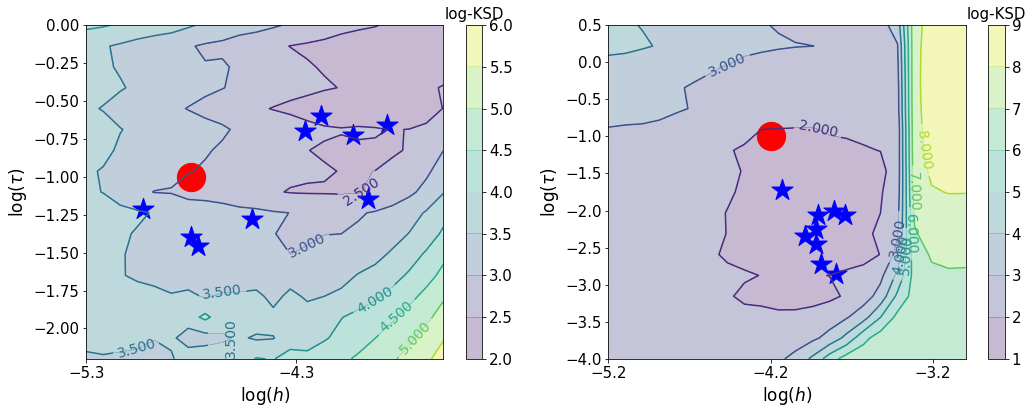

In [5]:
# ==================
# target: 5 seconds
# opt_sgld_list = [(-4.685606, np.log10(0.03274549)), (-4.124953, np.log10(0.30538556)), 
#                    (-4.1753, np.log10(0.46415886))]
# opt_sgldCV_list = [(-3.9677866, np.log10(0.0053366995)), (-3.7319977, np.log10(0.0015199113)), 
#                    (-3.5236366, np.log10(0.046415884))]

list_params_sgld_5 = [(-4.26, 0.20), (-3.87, 0.22), (-4.03, 0.19),
                     (-4.77, 0.035), (-5.03, 0.061), (-4.18, 0.25),
                      (-4.51, 0.053), (-4.80, 0.040), (-3.96, 0.071)
                     ]
list_params_sgldCV_5 = [(-3.89, 0.0019), (-4.13, 0.019), (-3.74, 0.0087),
                        (-3.92, 0.0057), (-3.91, 0.0087), (-3.92, 0.0035),
                        (-3.81, 0.01), (-3.80, 0.0014), (-3.99, 0.0046)
                       ]

opt_sgld_list = [(elem[0], np.log10(elem[1])) for elem in list_params_sgld_5]
opt_sgldCV_list = [(elem[0], np.log10(elem[1])) for elem in list_params_sgldCV_5]

opt_sgld_default = (-4.8, np.log10(0.1))
opt_sgldCV_default = (-4.2, np.log10(0.1))
# ==================

    
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

time_budget = 5.0
    
for idx, CV in enumerate([False, True]):
    
    if CV:
        output_dir = "outputs/LR_2d_grid_search/sgld_CV_5sec"
        ksd_mat_LR = np.genfromtxt(f"{output_dir}/LR_2D_gridsearch_high_res_sgld_CV_5sec.txt")
    else:
        output_dir = "outputs/LR_2d_grid_search/sgld_5sec"
        output_dir = "outputs/LR_2d_grid_search/sgld_4.0sec"
        ksd_mat_LR = np.genfromtxt(f"{output_dir}/LR_2d_grid_search4.0sec.txt")
    
        
    CV_string = "_CV" if CV else ""    

    logdt_grid = np.arange(-7,-2.6, 0.2)

    if CV:
        logdt_grid = np.linspace(-5.2,-3, 22)
        log_b_s_r_grid = np.linspace(-4, 0.5, 17)
        # log_b_s_r_grid = np.arange(-5, 0., 0.4)
    else:
        logdt_grid = np.linspace(-5.3,-3.6, 22)
        log_b_s_r_grid = np.linspace(-2.2,0, 17)
        # log_b_s_r_grid = np.arange(-3.5, 0., 0.4)

    XX, YY = np.meshgrid(logdt_grid, log_b_s_r_grid)


    log_ksd_mat = np.log(ksd_mat_LR)


    CS1 = ax[idx].contourf(XX, YY , log_ksd_mat, alpha=0.3)#, levels=[1,20,120])
    CS2 = ax[idx].contour(XX, YY , log_ksd_mat)#, levels=[1,20,120])
    ax[idx].clabel(CS2, inline=True, fontsize=14)
    ax[idx].set_xlabel(r"$\log(h)$", size=17)
    ax[idx].set_ylabel(r"$\log(\tau)$", size=17)
    ax[idx].set_xticks(np.arange(logdt_grid[0],-2.6, 1.))

    if CV:
        for opt_tuple_sgldCV in  opt_sgldCV_list:
            ax[idx].scatter(*opt_tuple_sgldCV, c='b', marker="*", 
                            s=500, label=fr"($log(h)$, $\tau$)={[round(e, 2) for e in opt_tuple_sgldCV]}")
        ax[idx].scatter(*opt_sgldCV_default, c='r', marker="o", s=800)
    else:
        for opt_tuple_sgld in opt_sgld_list:
            ax[idx].scatter(*opt_tuple_sgld, c='b', marker="*", 
                            s=500, label=fr"($log(h)$, $\tau$)={[round(e,2) for e in opt_tuple_sgld]}")
        ax[idx].scatter(*opt_sgld_default, c='r', marker="o", s=800)
    CS1 = fig.colorbar(CS1, ax=ax[idx])
    CS1.ax.set_title("log-KSD", size=15)
#     ax[idx].set_title(f"Logistic regression for sgld{CV_string}\n time budget: {time_budget}sec", size=16)

#     ax[idx].legend(fontsize=13, loc=2)
    
plt.tight_layout()



# plt.savefig(f"images/LR_2D_gridsearch_sgld-sgldCV_5sec.png")



In [4]:
opt_sgld_list

[(-4.26, -0.6989700043360187),
 (-3.87, -0.6575773191777937),
 (-4.03, -0.721246399047171),
 (-4.77, -1.4559319556497243),
 (-5.03, -1.214670164989233),
 (-4.18, -0.6020599913279624),
 (-4.51, -1.275724130399211),
 (-4.8, -1.3979400086720375),
 (-3.96, -1.1487416512809248)]

In [62]:
print(np.linspace(-5.3,-3.6, 22).shape)
print(np.linspace(-2.2,0, 17).shape)

(22,)
(17,)


In [59]:
np.arange(-7,-2.6, 5)


array([-7.])

In [57]:
np.arange(-3.5, 0., 4).shape

(1,)

In [48]:
opt_sgldCV_default

(-4.2, -1.0)